### 统计生命周期信息
绘制生命周期时间线图、内存访问图（以时间为X轴，内存地址空间为Y轴），统计运行总时间，计算实际活跃率

#### 1. 数据预处理

##### 1.1 读取数据

In [12]:
page_size_byte = 4096

In [13]:
import pandas as pd
from sqlalchemy import create_engine
import glob
import os
workspace_dir = "data/embedding"
# 扫描 workspace_dir 目录下的所有 sqlite3 文件
db_files = glob.glob(os.path.join(workspace_dir, "*.sqlite3"))
print(f"检测到 {len(db_files)} 个数据库文件：")
for f in db_files:
    print(" -", os.path.basename(f))


检测到 2 个数据库文件：
 - akita_sim_d46kbro650uo4g74b3q0.sqlite3
 - akita_sim_d46ke70650ukbn5an32g.sqlite3


In [14]:
def extract_page_access(db_path):
    engine = create_engine(f"sqlite:///{db_path}")
    df = pd.read_sql_table('trace', engine)

    df['StartPage'] = df['Address'] // 4096
    df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

    mem_df = df[
        df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) |
        (
            df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) &
            (df['Location'].str.contains('DRAM', na=False))
        )
    ]

    rows = []
    for _, row in mem_df.iterrows():
        for page in range(row['StartPage'], row['EndPage'] + 1):
            rows.append({
                'DeviceID': row['DeviceID'],
                'PageID': page,
                'AccessType': row['What'],
                'StartTime': row['StartTime'],
                'EndTime': row['EndTime'],
            })
    page_access_df = pd.DataFrame(rows)
    return df, page_access_df

##### 1.2 处理生命周期和内存分配

In [15]:
def analyze_lifecycle(df, page_access_df):
    page_access_df = page_access_df.sort_values(by=["PageID", "StartTime"]).reset_index(drop=True)
    max_time = page_access_df["EndTime"].max()
    lifecycles = []

    for page_id, group in page_access_df.groupby("PageID"):
        group = group.sort_values(by="StartTime")
        chunk = []
        in_lifecycle = False

        for _, row in group.iterrows():
            access_type = row["AccessType"]

            if "*mem.AllocateReq" in access_type:
                if in_lifecycle and chunk:
                    alloc_time = chunk[0]["StartTime"]
                    free_time = max_time
                    access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                    first_access = min([r["StartTime"] for r in access_rows], default=None)
                    last_access = max([r["EndTime"] for r in access_rows], default=None)
                    lifecycles.append({
                        "PageID": page_id,
                        "AllocateTime": alloc_time,
                        "FreeTime": free_time,
                        "LifeDuration": free_time - alloc_time,
                        "FirstAccessTime": first_access,
                        "LastAccessTime": last_access,
                        "RealLifeDuration": (last_access - alloc_time) if first_access and last_access else None,
                    })
                in_lifecycle = True
                chunk = [row]

            elif in_lifecycle:
                chunk.append(row)
                if "*mem.FreeReq" in access_type:
                    alloc_time = chunk[0]["StartTime"]
                    free_time = row["StartTime"]
                    access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                    first_access = min([r["StartTime"] for r in access_rows], default=None)
                    last_access = max([r["EndTime"] for r in access_rows], default=None)
                    lifecycles.append({
                        "PageID": page_id,
                        "AllocateTime": alloc_time,
                        "FreeTime": free_time,
                        "LifeDuration": free_time - alloc_time,
                        "FirstAccessTime": first_access,
                        "LastAccessTime": last_access,
                        "RealLifeDuration": (last_access - alloc_time) if first_access and last_access else None,
                    })
                    chunk = []
                    in_lifecycle = False

        if in_lifecycle and chunk:
            alloc_time = chunk[0]["StartTime"]
            free_time = max_time
            access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
            first_access = min([r["StartTime"] for r in access_rows], default=None)
            last_access = max([r["EndTime"] for r in access_rows], default=None)
            lifecycles.append({
                "PageID": page_id,
                "AllocateTime": alloc_time,
                "FreeTime": free_time,
                "LifeDuration": free_time - alloc_time,
                "FirstAccessTime": first_access,
                "LastAccessTime": last_access,
                "RealLifeDuration": (last_access - alloc_time) if first_access and last_access else None,
            })

    lifecycle_df = pd.DataFrame(lifecycles)
    return lifecycle_df


In [16]:
def calculate_memory_occupancy(lifecycle_df, max_time):
    """计算内存占用统计"""
    # 分配-释放阶段
    alloc_free_events = []
    for _, row in lifecycle_df.iterrows():
        alloc_free_events.append((row['AllocateTime'], 1))  # 分配
        alloc_free_events.append((row['FreeTime'], -1))     # 释放
    
    # 首次访问-最后访问阶段
    access_events = []
    for _, row in lifecycle_df.iterrows():
        if pd.notna(row['FirstAccessTime']) and pd.notna(row['LastAccessTime']):
            access_events.append((row['FirstAccessTime'], 1))  # 开始访问
            access_events.append((row['LastAccessTime'], -1))  # 结束访问
    
    def calculate_metrics(events, max_time):
        if not events:
            return 0, 0
        
        events.sort()
        current_occupancy = 0
        max_occupancy = 0
        cumulative_occupancy = 0
        last_time = 0
        
        for time, change in events:
            cumulative_occupancy += current_occupancy * (time - last_time)
            current_occupancy += change
            max_occupancy = max(max_occupancy, current_occupancy)
            last_time = time
        
        # 处理最后时间段
        cumulative_occupancy += current_occupancy * (max_time - last_time)
        
        return max_occupancy, cumulative_occupancy
    
    alloc_max, alloc_cumulative = calculate_metrics(alloc_free_events, max_time)
    access_max, access_cumulative = calculate_metrics(access_events, max_time)
    
    # 计算占用比
    max_ratio = (access_max / alloc_max * 100) if alloc_max > 0 else 0
    cumulative_ratio = (access_cumulative / alloc_cumulative * 100) if alloc_cumulative > 0 else 0
    
    return {
        'alloc_max_pages': alloc_max,
        'alloc_max_kb': alloc_max * page_size_byte / 1024,
        'alloc_cumulative_pages': alloc_cumulative,
        'alloc_cumulative_bs': alloc_cumulative * page_size_byte,
        'access_max_pages': access_max,
        'access_max_kb': access_max * page_size_byte / 1024,
        'access_cumulative_pages': access_cumulative,
        'access_cumulative_bs': access_cumulative * page_size_byte,
        'max_ratio_percent': max_ratio,
        'cumulative_ratio_percent': cumulative_ratio
    }

#### 2. 生命周期和内存占用

##### 2.1 绘制生命周期时间线图

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lifecycle_timeline(lifecycle_df, filename):
    plt.figure(figsize=(18, 40))

    # 创建统一的 y 轴映射
    all_pages = sorted(lifecycle_df['PageID'].unique())
    y_pos_map = {page: i for i, page in enumerate(all_pages)}

    # 绘制每段生命周期
    for i, row in lifecycle_df.iterrows():
        page = row['PageID']
        y_pos = y_pos_map[page]

        # 分配时间
        plt.scatter(row['AllocateTime'], y_pos,
                    color='limegreen', marker='*', s=80,
                    label='Allocate' if i == 0 else '')

        # 释放时间
        plt.scatter(row['FreeTime'], y_pos,
                    color='red', marker='x', s=60, linewidth=2,
                    label='Free' if i == 0 else '')

        # 生命周期虚线
        plt.hlines(y=y_pos,
                xmin=row['AllocateTime'],
                xmax=row['FreeTime'],
                colors='black', linestyles='dashed', alpha=0.5, linewidth=1)

        # 首次访问
        if pd.notnull(row['FirstAccessTime']):
            plt.scatter(row['FirstAccessTime'], y_pos,
                        color='dodgerblue', marker='<', s=40,
                        label='First Access' if i == 0 else '')

        # 最后访问
        if pd.notnull(row['LastAccessTime']):
            plt.scatter(row['LastAccessTime'], y_pos,
                        color='darkorange', marker='>', s=40,
                        label='Last Access' if i == 0 else '')

        # 读写访问时间线
        if pd.notnull(row['FirstAccessTime']) and pd.notnull(row['LastAccessTime']):
            plt.hlines(y=y_pos,
                    xmin=row['FirstAccessTime'],
                    xmax=row['LastAccessTime'],
                    colors='black', alpha=0.7, linewidth=1.5)

    # 设置坐标轴标签
    plt.yticks(range(len(all_pages)),
            [hex(page * page_size_byte) for page in all_pages],
            fontsize=10)  # 页物理地址
    plt.xticks(fontsize=10)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Physical Page Address (hex)', fontsize=12)
    plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

    # 计算时间范围
    min_time = min(lifecycle_df['AllocateTime'].min(), lifecycle_df['FirstAccessTime'].min(skipna=True))
    max_time = max(lifecycle_df['FreeTime'].max(), lifecycle_df['LastAccessTime'].max(skipna=True))
    plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
    plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

    # 添加网格线
    plt.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.grid(True, axis='y', linestyle=':', alpha=0.3)

    # 图例右侧展示
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            borderaxespad=0.,
            frameon=True,
            fontsize=11,
            title='Event Types',
            title_fontsize=12)

    # 调整布局
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()

    # 创建结果目录并保存图像到workspace
    results_dir = os.path.join(workspace_dir, "results")
    os.makedirs(results_dir, exist_ok=True)
    
    # 使用文件名创建唯一的图片名称
    timeline_path = os.path.join(results_dir, f'{filename}_lifecycle_timeline.png')
    plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
    
    print(f"已保存生命周期时间线图: {timeline_path}")
    plt.show()

# 绘制内存读写访问时间线图
def plot_memory_access(page_access_df, filename):
    plt.figure(figsize=(18, 20))

    # 创建统一的 y 轴映射（仅基于 page_access_df 的 PageID）
    all_pages = sorted(page_access_df['PageID'].unique())
    y_pos_map = {page: i for i, page in enumerate(all_pages)}

    # 绘制每个读写访问的持续时间（横线）
    for _, row in page_access_df.iterrows():
        y_pos = y_pos_map[row['PageID']]
        
        # 根据访问类型选择颜色和样式
        if row['AccessType'] == '*mem.ReadReq':
            color = 'dodgerblue'
            linestyle = '-'  # 实线表示读
            label = 'Read' if _ == 0 or 'Read' not in plt.gca().get_legend_handles_labels()[1] else ''
        else:  # '*mem.WriteReq'
            color = 'crimson'
            linestyle = '--'  # 虚线表示写
            label = 'Write' if _ == 0 or 'Write' not in plt.gca().get_legend_handles_labels()[1] else ''
        
        # 生成在 StartTime 到 EndTime 之间的横向点
        x_points = np.linspace(row['StartTime'], row['EndTime'], num=20)
        y_points = np.full_like(x_points, y_pos)
        
        plt.scatter(
            x_points,
            y_points,
            color=color,
            s=6,           # 控制点的大小
            alpha=0.7,
            label=label
        )

        # 绘制横线（连接 StartTime 和 EndTime）
        # plt.hlines(
        #     y=y_pos,
        #     xmin=row['StartTime'],
        #     xmax=row['EndTime'],
        #     colors=color,
        #     linestyles=linestyle,
        #     alpha=0.7,
        #     linewidth=15,
        #     label=label
        # )
        
        # 可选：在访问的起点和终点添加标记
        # plt.scatter(
        #     row['StartTime'], y_pos,
        #     color=color,
        #     marker='>',  # 右箭头表示开始
        #     s=50,
        #     alpha=0.9,
        #     label=''  # 不重复添加图例
        # )
        # plt.scatter(
        #     row['EndTime'], y_pos,
        #     color=color,
        #     marker='<',  # 左箭头表示结束
        #     s=50,
        #     alpha=0.9,
        #     label=''
        # )

    # 设置坐标轴
    # plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
    plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
    plt.xticks(fontsize=10)
    plt.xlabel('Time (seconds)', fontsize=12)
    # plt.ylabel('Page ID', fontsize=12) # y轴显示page id
    plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
    plt.title('Memory Access Timeline\n(Read vs Write Duration)', fontsize=16, pad=20)

    # 调整坐标轴范围
    min_time = page_access_df['StartTime'].min()
    max_time = page_access_df['EndTime'].max()
    plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
    plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

    # 添加网格线
    plt.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.grid(True, axis='y', linestyle=':', alpha=0.3)

    # 自定义图例（避免重复）
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 去重
    plt.legend(
        unique_labels.values(),
        unique_labels.keys(),
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0.,
        frameon=True,
        fontsize=11,
        title='Access Type',
        title_fontsize=12
    )

    # 调整布局
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    # 创建结果目录并保存图像到workspace
    results_dir = os.path.join(workspace_dir, "results")
    os.makedirs(results_dir, exist_ok=True)
    
    # 使用文件名创建唯一的图片名称
    access_path = os.path.join(results_dir, f'{filename}_memory_access.png')
    plt.savefig(access_path, dpi=300, bbox_inches='tight')
    
    print(f"已保存内存访问图: {access_path}")
    plt.show()
    

##### 2.2 保存所有文件的内存占用

In [18]:
def get_occupancy_curve(lifecycle_df, max_time, mode='alloc'):
    """
    获取内存占用曲线数据
    mode: 'alloc' 或 'access'
    """
    if mode == 'alloc':
        # 分配-释放阶段
        events = []
        for _, row in lifecycle_df.iterrows():
            events.append((row['AllocateTime'], 1))  # 分配
            events.append((row['FreeTime'], -1))     # 释放
    else:
        # 访问阶段
        events = []
        for _, row in lifecycle_df.iterrows():
            if pd.notna(row['FirstAccessTime']) and pd.notna(row['LastAccessTime']):
                events.append((row['FirstAccessTime'], 1))  # 开始访问
                events.append((row['LastAccessTime'], -1))  # 结束访问
    
    if not events:
        return [0], [0]
    
    # 排序事件
    events.sort()
    
    # 生成时间序列和占用值
    times = [0]
    occupancy = [0]
    current_occ = 0
    
    for time, change in events:
        # 添加事件前的时间点
        if time > times[-1]:
            times.append(time)
            occupancy.append(current_occ)
        
        # 更新占用值
        current_occ += change
        times.append(time)
        occupancy.append(current_occ)
    
    # 添加最后时间点
    if times[-1] < max_time:
        times.append(max_time)
        occupancy.append(current_occ)
    
    return times, occupancy


=== 处理文件: akita_sim_d46kbro650uo4g74b3q0 ===

显示 akita_sim_d46kbro650uo4g74b3q0 的生命周期时间线图:
已保存生命周期时间线图: data/embedding\results\akita_sim_d46kbro650uo4g74b3q0_lifecycle_timeline.png


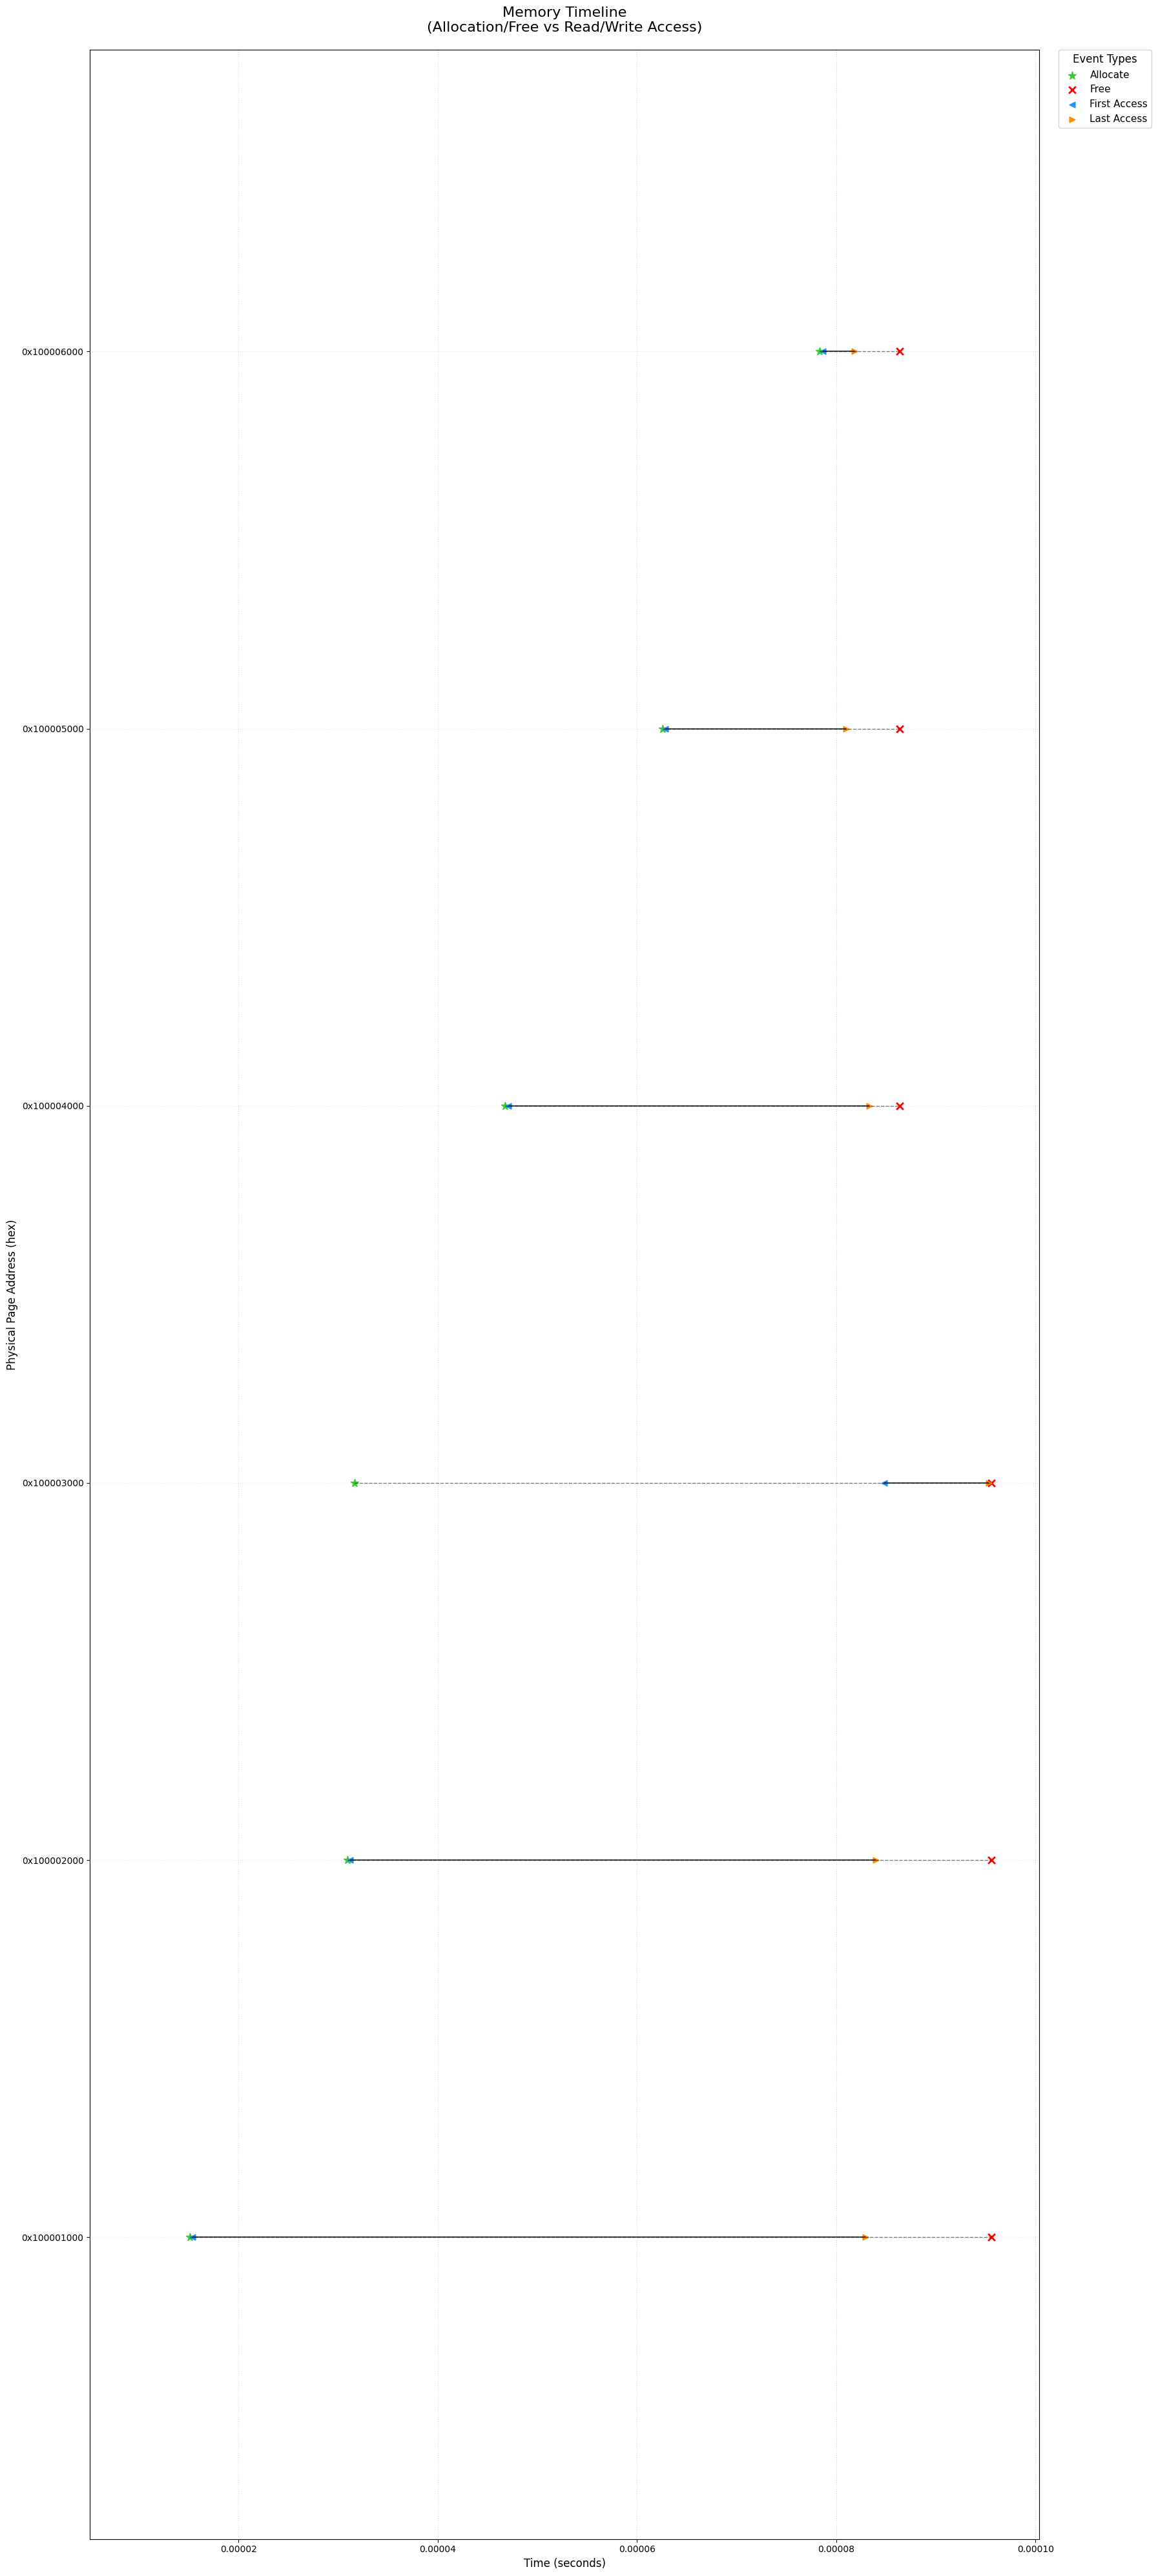


显示 akita_sim_d46kbro650uo4g74b3q0 的内存访问图:
已保存内存访问图: data/embedding\results\akita_sim_d46kbro650uo4g74b3q0_memory_access.png


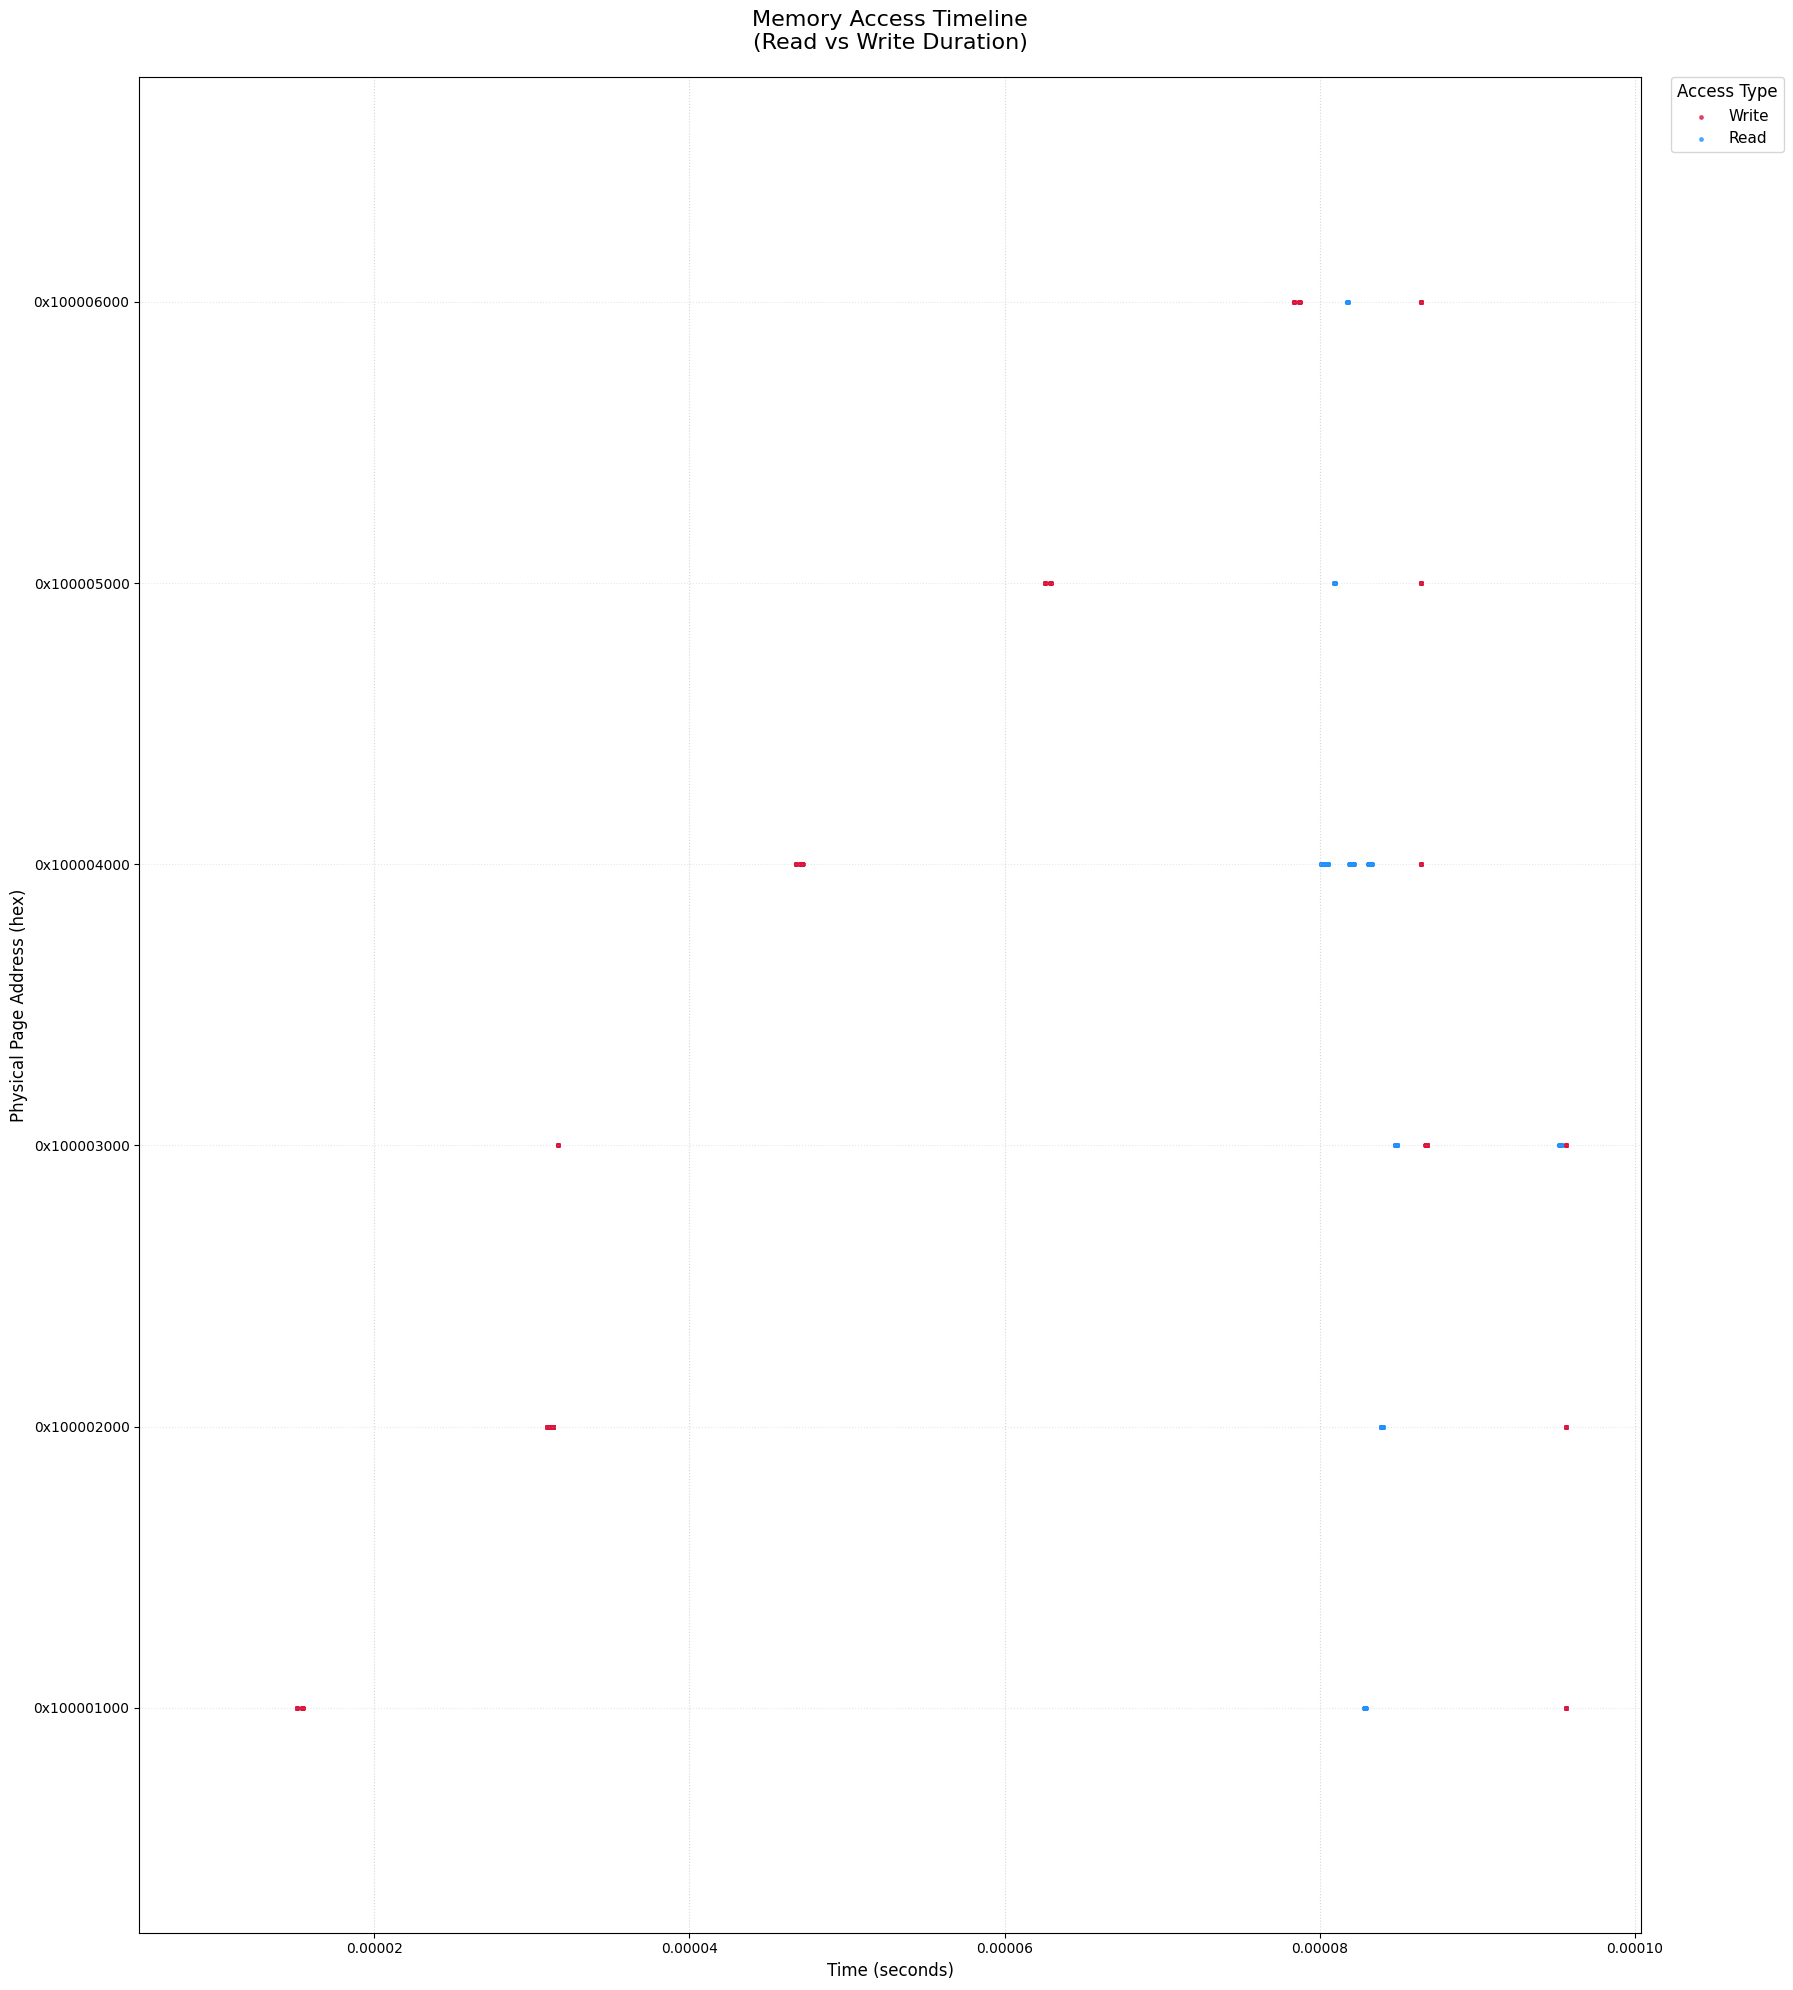


内存占用统计 - akita_sim_d46kbro650uo4g74b3q0:
///分配-释放///
最大占用：6 页 (24.00 KB)
累积占用：0.000281 页×秒 (1.15 B·s)
///首次访问-最后访问///
最大占用：5 页 (20.00 KB)
累积占用：0.000188 页×秒 (0.77 B·s)
///占用比///
最大占用比（访问/分配）：83.33%
累积占用比（访问/分配）：67.11%

=== 处理文件: akita_sim_d46ke70650ukbn5an32g ===

显示 akita_sim_d46ke70650ukbn5an32g 的生命周期时间线图:
已保存生命周期时间线图: data/embedding\results\akita_sim_d46ke70650ukbn5an32g_lifecycle_timeline.png


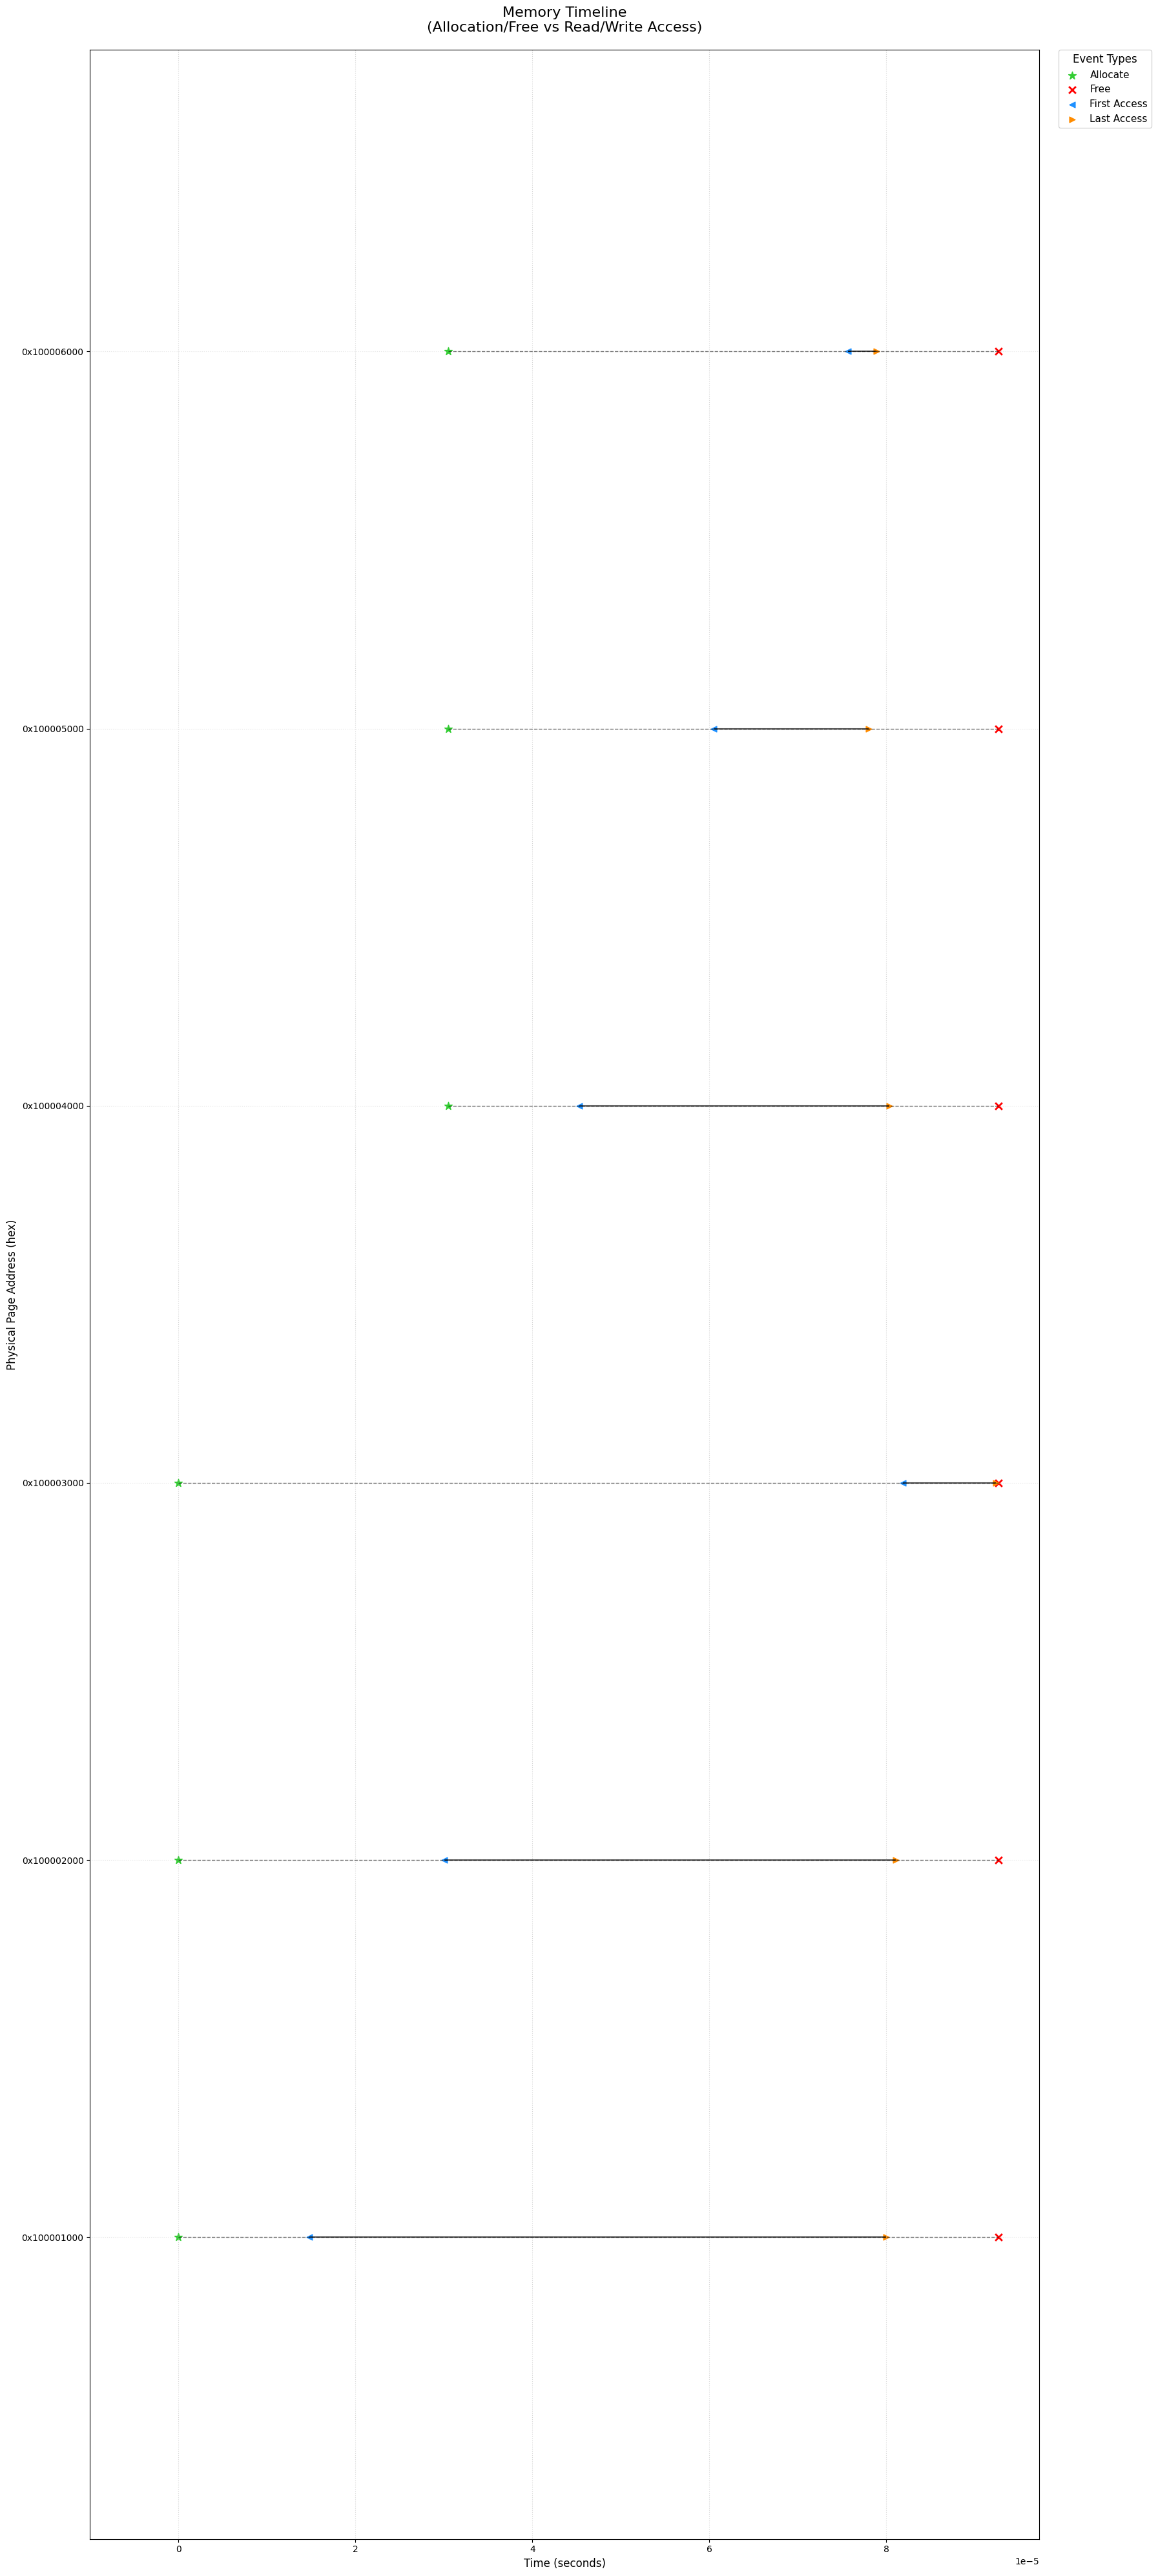


显示 akita_sim_d46ke70650ukbn5an32g 的内存访问图:
已保存内存访问图: data/embedding\results\akita_sim_d46ke70650ukbn5an32g_memory_access.png


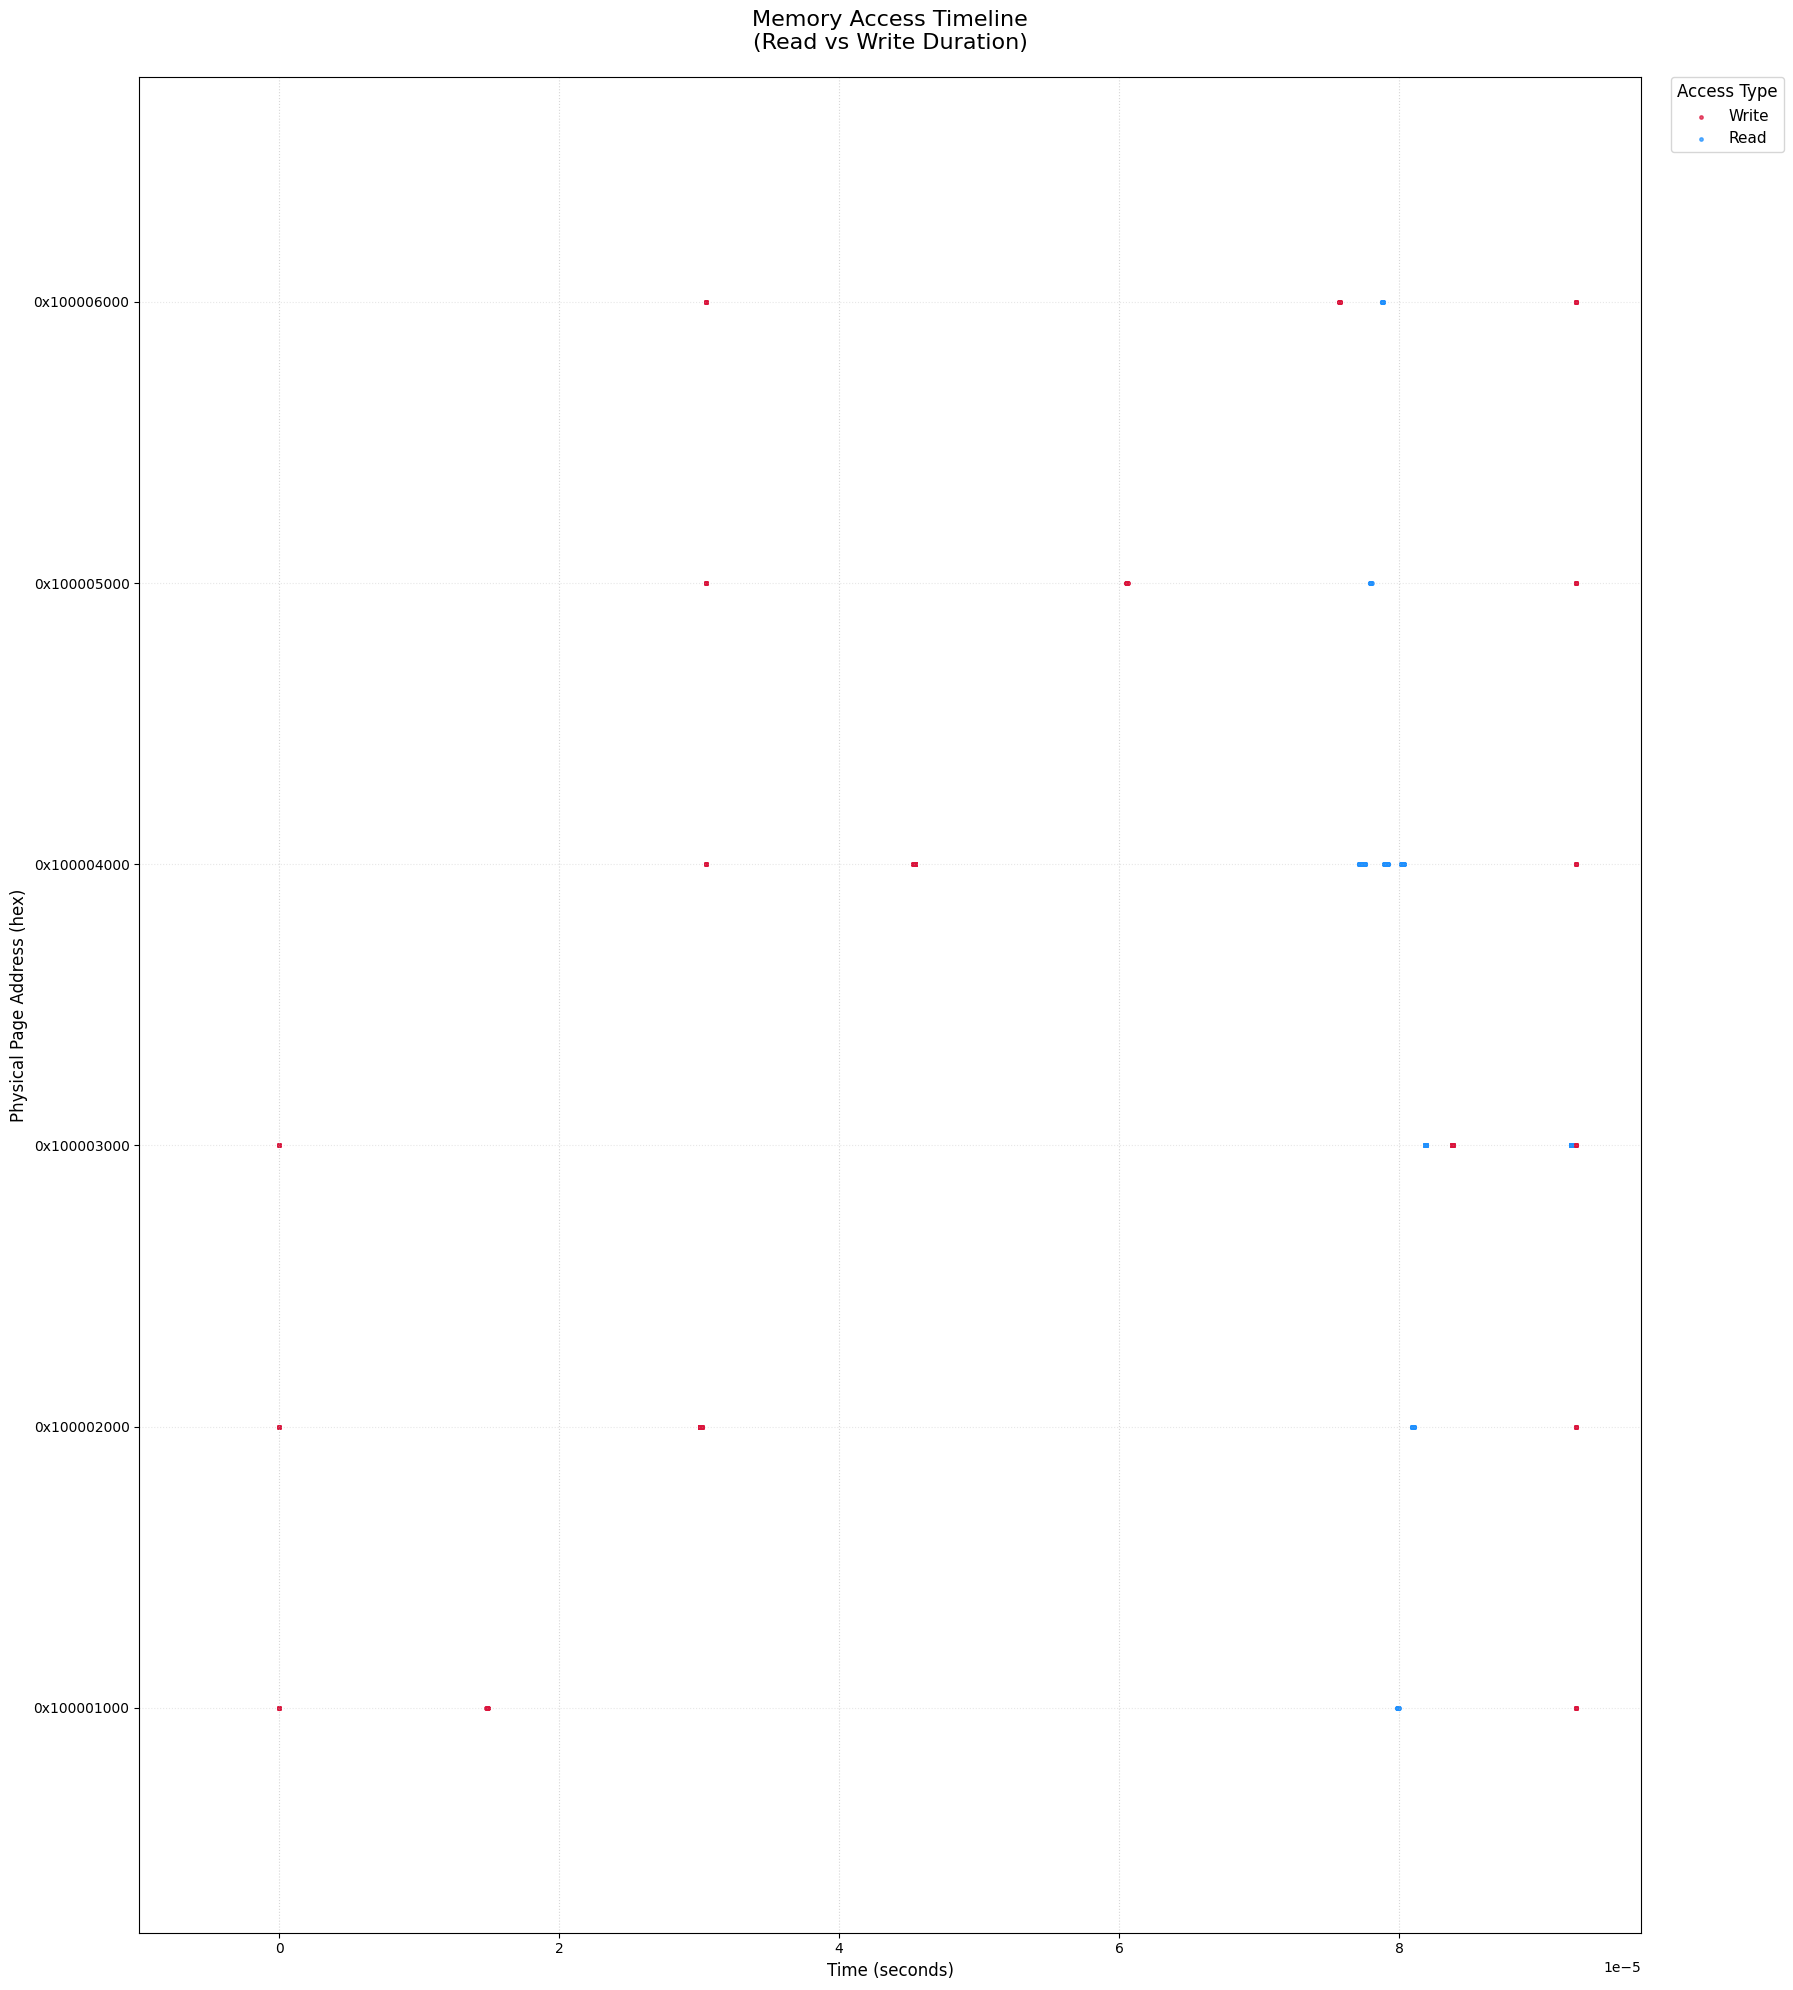


内存占用统计 - akita_sim_d46ke70650ukbn5an32g:
///分配-释放///
最大占用：6 页 (24.00 KB)
累积占用：0.000465 页×秒 (1.90 B·s)
///首次访问-最后访问///
最大占用：5 页 (20.00 KB)
累积占用：0.000182 页×秒 (0.75 B·s)
///占用比///
最大占用比（访问/分配）：83.33%
累积占用比（访问/分配）：39.27%


In [19]:
# 存储所有文件的曲线数据用于整合图
all_curve_data = []
all_memory_data = []
summary_list = []
english_summary_list = []
chinese_summary_list = []
for db_path in db_files:
    name = os.path.basename(db_path).replace('.sqlite3', '')
    print(f"\n=== 处理文件: {name} ===")

    # 1. 提取页面访问数据
    df, page_access_df = extract_page_access(db_path)
    
    # 2. 分析生命周期
    lifecycle_df = analyze_lifecycle(df, page_access_df)
    
    # 3. 计算内存占用统计
    max_time = page_access_df["EndTime"].max()
    mem_stats = calculate_memory_occupancy(lifecycle_df, max_time)
    
    # 4. 计算占用曲线数据
    alloc_curve = get_occupancy_curve(lifecycle_df, max_time, mode='alloc')
    access_curve = get_occupancy_curve(lifecycle_df, max_time, mode='access')
    
    # 存储曲线数据用于整合图
    all_curve_data.append((alloc_curve, access_curve, name))
    
    # 5. 计算生命周期活跃率（原有功能）
    lifecycle_df['UsageRatio'] = lifecycle_df['RealLifeDuration'] / lifecycle_df['LifeDuration']
    lifecycle_df['UsageRatio'] = lifecycle_df['UsageRatio'].fillna(0)

    total_alloc = lifecycle_df['LifeDuration'].sum()
    total_active = lifecycle_df['RealLifeDuration'].sum()
    usage_ratio = total_active / total_alloc if total_alloc > 0 else 0

    simulation_time_df = df[(df['Kind']=='Simulation') & (df['What']=='Simulation') & (df['Location']=='Driver')]
    simulation_time = (simulation_time_df['EndTime'] - simulation_time_df['StartTime']).astype(float).iloc[0]

    # 6. 绘制单独的图表 - 每个文件都会在notebook中显示
    print(f"\n显示 {name} 的生命周期时间线图:")
    plot_lifecycle_timeline(lifecycle_df, name)
    
    print(f"\n显示 {name} 的内存访问图:")
    plot_memory_access(page_access_df, name)
    
    # 7. 存储内存占用数据
    all_memory_data.append({
        'filename': name,
        'alloc_max_pages': mem_stats['alloc_max_pages'],
        'access_max_pages': mem_stats['access_max_pages'],
        'alloc_max_kb': mem_stats['alloc_max_kb'],
        'access_max_kb': mem_stats['access_max_kb']
    })

    # 8. 添加到汇总列表
    english_data = {
        "File": name + ".sqlite3",
        "ActualLifeTime(s)": total_active,
        "TotalLifeTime(s)": total_alloc,
        "ActiveRatio(%)": usage_ratio * 100,
        "RunTime(s)": simulation_time,
        "AllocFree_MaxPages(page)": mem_stats['alloc_max_pages'],
        "AllocFree_MaxKB(KB)": mem_stats['alloc_max_kb'],
        "AllocFree_CumulativePages(page*s)": mem_stats['alloc_cumulative_pages'],
        "AllocFree_CumulativeBS(byte*s)": mem_stats['alloc_cumulative_bs'],
        "Access_MaxPages(page)": mem_stats['access_max_pages'],
        "Access_MaxKB(KB)": mem_stats['access_max_kb'],
        "Access_CumulativePages(page*s)": mem_stats['access_cumulative_pages'],
        "Access_CumulativeBS(byte*s)": mem_stats['access_cumulative_bs'],
        "MaxRatio(%)": mem_stats['max_ratio_percent'],
        "CumulativeRatio(%)": mem_stats['cumulative_ratio_percent'],
    }
    
    chinese_data = {
        "文件": name + ".sqlite3",
        "实际生命周期(s)": total_active,
        "总生命周期(s)": total_alloc,
        "活跃率(%)": usage_ratio * 100,
        "运行时间(s)": simulation_time,
        "分配释放_最大占用页数(页)": mem_stats['alloc_max_pages'],
        "分配释放_最大占用字节数(KB)": mem_stats['alloc_max_kb'],
        "分配释放_累积占用(页*秒)": mem_stats['alloc_cumulative_pages'],
        "分配释放_累积占用(字节*秒)": mem_stats['alloc_cumulative_bs'],
        "访问_最大占用页数(页)": mem_stats['access_max_pages'],
        "访问_最大占用字节数(KB)": mem_stats['access_max_kb'],
        "访问_累积占用(页*秒)": mem_stats['access_cumulative_pages'],
        "访问_累积占用(字节*秒)": mem_stats['access_cumulative_bs'],
        "最大占用比(%)": mem_stats['max_ratio_percent'],
        "累积占用比(%)": mem_stats['cumulative_ratio_percent'],
    }
    
    english_summary_list.append(english_data)
    chinese_summary_list.append(chinese_data)
    
    # 9. 打印内存占用信息
    print(f"\n内存占用统计 - {name}:")
    print(f"///分配-释放///")
    print(f"最大占用：{mem_stats['alloc_max_pages']} 页 ({mem_stats['alloc_max_kb']:.2f} KB)")
    print(f"累积占用：{mem_stats['alloc_cumulative_pages']:.6f} 页×秒 ({mem_stats['alloc_cumulative_bs']:.2f} B·s)")
    print(f"///首次访问-最后访问///")
    print(f"最大占用：{mem_stats['access_max_pages']} 页 ({mem_stats['access_max_kb']:.2f} KB)")
    print(f"累积占用：{mem_stats['access_cumulative_pages']:.6f} 页×秒 ({mem_stats['access_cumulative_bs']:.2f} B·s)")
    print(f"///占用比///")
    print(f"最大占用比（访问/分配）：{mem_stats['max_ratio_percent']:.2f}%")
    print(f"累积占用比（访问/分配）：{mem_stats['cumulative_ratio_percent']:.2f}%")

##### 2.3 绘制整合后的内存占用图

In [20]:
def plot_combined_occupancy_curves(all_curve_data):
    plt.figure(figsize=(16, 8))
    
    # 使用光谱颜色映射，确保颜色分布均匀
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(all_curve_data)))
    
    for i, (alloc_data, access_data, filename) in enumerate(all_curve_data):
        alloc_times, alloc_usage = alloc_data
        access_times, access_usage = access_data
        
        color = colors[i]
        
        # 绘制分配-释放占用曲线 - 使用较粗的实线
        plt.step(alloc_times, alloc_usage, where='post', 
                label=f'{filename} (Alloc)', color=color, linewidth=3, alpha=0.9)
        
        # 绘制访问占用曲线 - 使用较细的虚线
        plt.step(access_times, access_usage, where='post', 
                label=f'{filename} (Access)', color=color, linewidth=1.5, 
                linestyle='--', alpha=0.7)
    
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Memory Occupancy (pages)', fontsize=12)
    plt.title('Memory Occupancy Over Time:\nAll Files Comparison (Allocation vs Access)', fontsize=16)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    # 创建结果目录并保存图像到workspace
    results_dir = os.path.join(workspace_dir, "results")
    os.makedirs(results_dir, exist_ok=True)

    combined_plot_path = os.path.join(results_dir, 'combined_memory_occupancy.png')
    plt.savefig(combined_plot_path, dpi=300, bbox_inches='tight')
    
    print(f"已保存整合内存占用图: {combined_plot_path}")
    plt.show()
    
    print("显示整合内存占用图:")

已保存整合内存占用图: data/embedding\results\combined_memory_occupancy.png


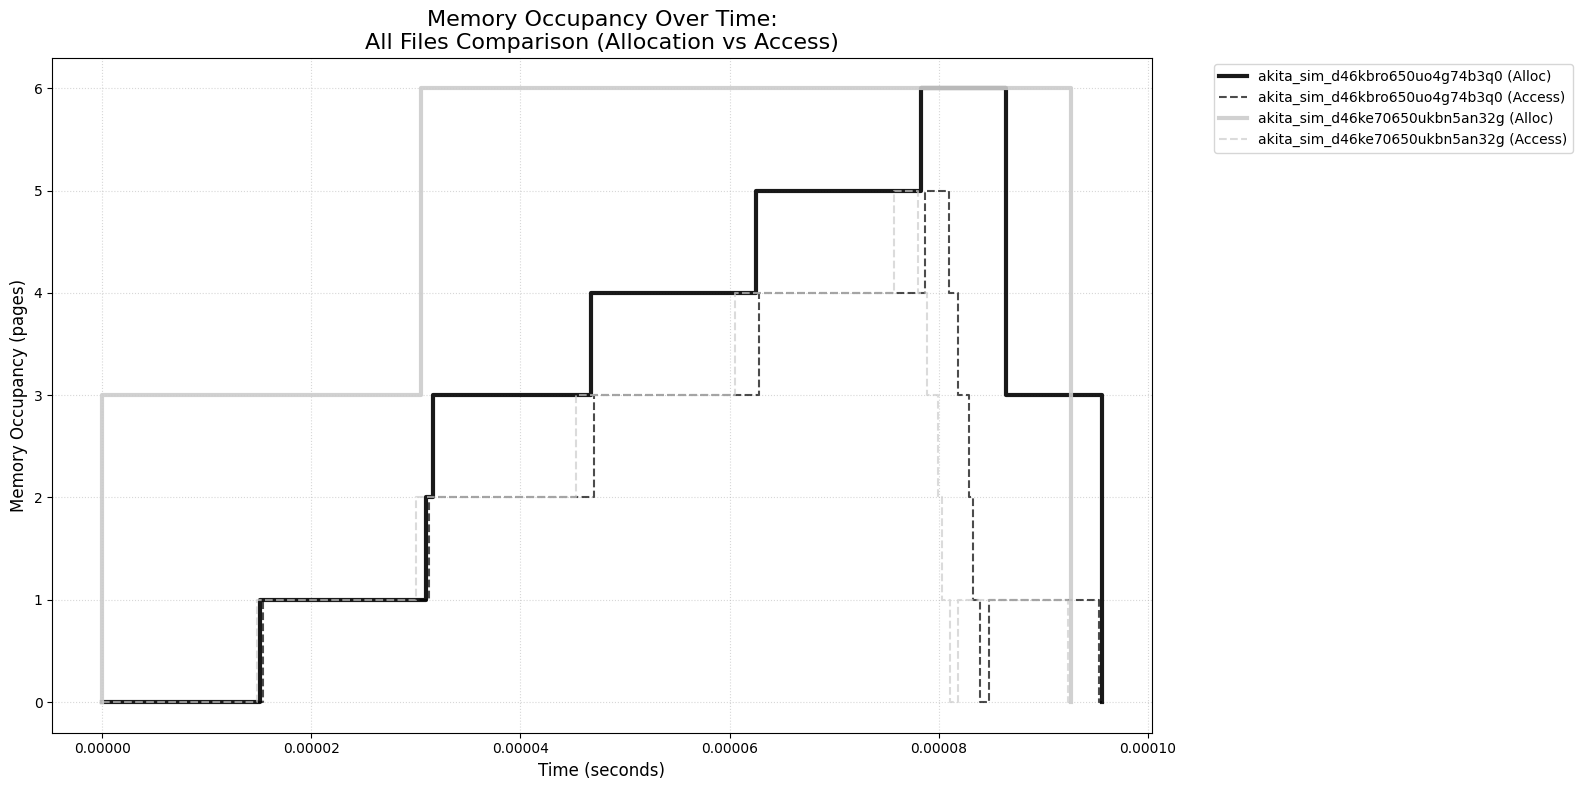

显示整合内存占用图:


In [21]:
import numpy as np
# 生成整合的内存占用图 - 在notebook中显示
if all_memory_data:
    plot_combined_occupancy_curves(all_curve_data)

##### 2.4 生成excel文件

In [22]:
# 生成汇总Excel文件 - 在同一sheet中先英文后中文

# 创建英文和中文的DataFrame
english_df = pd.DataFrame(english_summary_list)
chinese_df = pd.DataFrame(chinese_summary_list)

# 创建Excel写入器
excel_path = workspace_dir + "/memory_summary.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    # 创建新的DataFrame，包含英文和中文两部分
    combined_data = []
    
    # 添加英文列名
    combined_data.append(list(english_df.columns))
    
    # 添加英文数据
    for _, row in english_df.iterrows():
        combined_data.append(list(row))
    
    # 添加空行分隔
    combined_data.append([""] * len(english_df.columns))
    
    # 添加中文列名
    combined_data.append(list(chinese_df.columns))
    
    # 添加中文数据
    for _, row in chinese_df.iterrows():
        combined_data.append(list(row))
    
    # 创建DataFrame并写入Excel
    combined_df = pd.DataFrame(combined_data)
    combined_df.to_excel(writer, sheet_name='Memory Summary', index=False, header=False)

print(f"\n已生成汇总表: {excel_path}")



已生成汇总表: data/embedding/memory_summary.xlsx
